In [1]:
%cd ..

/Users/crupley/gal/hoodie


In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
import cPickle as pickle
import matplotlib.pyplot as plt

In [3]:
from graph_tool.all import *

/usr/local/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:1456: PyGIWarning: Gtk was imported without specifying a version first. Use gi.require_version('Gtk', '3.0') before import to ensure that the right version gets loaded.
  from gi.repository import Gtk, Gdk, GdkPixbuf


In [6]:
f = pickle.load(open('features.pkl', 'rb'))
df = f.fsmooth.copy()
edges = pickle.load(open('edges.pkl', 'rb'))

In [5]:
g = Graph()

In [7]:
edges.head()

,node1,node2
edge,,
0,0,1086
1,0,4952
2,0,4067
3,0,2729
4,0,6339


In [8]:
g.add_edge_list(zip(edges.node1, edges.node2))

In [11]:
len(list(g.vertices()))

7334

In [12]:
len(list(g.edges()))

36902

In [23]:
from code.featurize import window, dist_by_node

In [15]:
dfsm = window(df, 37.78, 37.82, -122.43, -122.37)
print dfsm.shape

(917, 11)


In [16]:
edsm = edges[(edges.node1.apply(lambda x: x in set(dfsm.index.values))) &
             (edges.node2.apply(lambda x: x in set(dfsm.index.values)))]
edsm.shape

(4679, 2)

/Users/crupley/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


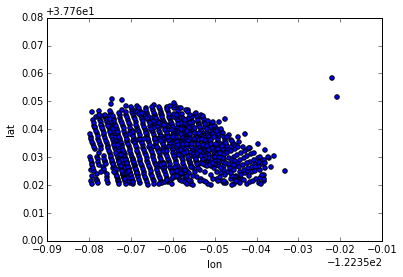

In [19]:
dfsm.plot(kind='scatter', x='lon', y='lat')

In [24]:
dist = edsm.apply(lambda x: dist_by_node(x.node1, x.node2, dfsm), axis=1)

In [26]:
print dist.shape
dist.head()

(4679,)


edge
191    0.000849
192    0.000955
193    0.001216
194    0.001504
195    0.001667
dtype: float64

In [73]:
gsm = Graph()

In [74]:
gp = gsm.new_graph_property('string')
gsm.graph_properties['Name'] = gp
gsm.graph_properties['Name'] = 'small graph'

In [83]:
eprop = gsm.new_edge_property("float")
gsm.edge_properties['dist'] = eprop
gsm.edge_properties['btw'] = eprop
gsm.list_properties()

Name           (graph)   (type: string, val: small graph)
btw            (edge)    (type: double)
dist           (edge)    (type: double)


In [76]:
gsm.add_edge_list(zip(edsm.node1, edsm.node2))

In [64]:
gsm.ep.dist[edge] = 1
gsm.ep.dist[edge]

1.0

In [66]:
dist.iloc[0]

0.0008490421073171345

In [77]:
len(list(gsm.edges()))

4679

In [78]:
for i, edge in enumerate(gsm.edges()):
    gsm.ep.dist[edge] = dist.iloc[i]

In [82]:
print gsm.ep.dist[(37, 5663)]
print dist[191]

0.000849042107317
0.000849042107317


In [34]:
edsm.head()

,node1,node2
edge,,
191,37,5663
192,37,3283
193,37,6975
194,37,4248
195,37,4104


In [43]:
gsm.edge(37, 5663)

<Edge object with source '37' and target '5663' at 0x123d2e6d8>

In [88]:
%time betweenness(gsm, eprop = gsm.ep.btw, weight = gsm.ep.dist)

CPU times: user 556 ms, sys: 4.68 ms, total: 561 ms
Wall time: 567 ms


(<PropertyMap object with key type 'Vertex' and value type 'double', for Graph 0x123d68e90, at 0x123d52310>,
 <PropertyMap object with key type 'Edge' and value type 'double', for Graph 0x123d68e90, at 0x122cddbd0>)

In [90]:
gsm.ep.btw[(37, 5663)]

7.385625867792677e-05

# full dataset

In [93]:
distfull = edges.apply(lambda x: dist_by_node(x.node1, x.node2, df), axis=1)

In [106]:
g = Graph()

In [107]:
# create graph properties
gp = g.new_graph_property('string')
g.graph_properties['Name'] = gp
g.graph_properties['Name'] = 'full graph'
eprop = g.new_edge_property("float")
g.edge_properties['dist'] = eprop
g.edge_properties['btw'] = eprop
g.list_properties()

Name           (graph)   (type: string, val: full graph)
btw            (edge)    (type: double)
dist           (edge)    (type: double)


In [108]:
# create edges and edge weights
g.add_edge_list(zip(edges.node1, edges.node2))
for i, edge in enumerate(g.edges()):
    g.ep.dist[edge] = distfull.iloc[i]

In [109]:
len(list(g.edges()))

36902

In [110]:
edges.head()

,node1,node2
edge,,
0,0,1086
1,0,4952
2,0,4067
3,0,2729
4,0,6339


In [113]:
print g.ep.dist[(0, 1086)]
print distfull.iloc[0]

0.00106363344249
0.00106363344249


In [172]:
# betweenness
%time betweenness(g, eprop = g.ep.btw, weight = g.ep.dist)

CPU times: user 23.2 s, sys: 207 ms, total: 23.4 s
Wall time: 24 s


(<PropertyMap object with key type 'Vertex' and value type 'double', for Graph 0x125e8e050, at 0x125f91050>,
 <PropertyMap object with key type 'Edge' and value type 'double', for Graph 0x125e8e050, at 0x125e8e3d0>)

In [115]:
g.ep.btw[(0, 1086)]

0.0009354814882146744

In [126]:
remove_parallel_edges(g)
remove_self_loops(g)

In [123]:
len(list(g.edges()))

36902

In [144]:
h = edge_hist(g, g.ep.btw)

In [161]:
np.argmax(g.ep['btw'].get_array())

28023

In [163]:
maxedge = list(g.edges())[28023]
maxedge

<Edge object with source '5562' and target '2602' at 0x124683cc8>

In [164]:
g.ep.btw[maxedge]

0.007749577530565062

In [165]:
g.remove_edge(maxedge)

In [166]:
len(list(g.edges()))

36901

In [168]:
len(list(g.vertices()))

7334

# reduce small graph

In [294]:
len(list(gsm.edges()))

36902

In [383]:
gsm = Graph(directed=False, prune=True)

# create graph properties
gp = gsm.new_graph_property('string')
gsm.graph_properties['Name'] = gp
gsm.graph_properties['Name'] = 'small graph'
eprop = gsm.new_edge_property("float")
gsm.edge_properties['dist'] = eprop
eprop = gsm.new_edge_property("float")
gsm.edge_properties['btw'] = eprop
gsm.list_properties()

# create edges and edge weights
gsm.add_edge_list(zip(edsm.node1, edsm.node2))
for i, edge in enumerate(gsm.edges()):
    gsm.ep.dist[edge] = dist.iloc[i]
    
    
remove_parallel_edges(g)
remove_self_loops(gsm)
print gsm.num_vertices() 
print gsm.num_edges()
print len(list(gsm.ep.dist.a))

Name           (graph)   (type: string, val: small graph)
btw            (edge)    (type: double)
dist           (edge)    (type: double)
7315
4679
4679


In [388]:
btwdfsm = pd.DataFrame({'edge': map(eval, map(str, list(gsm.edges()))),
                        'btw': list(gsm.ep.btw.fa)})
btwdfsm.sort_values('btw', ascending=False).head()

,btw,edge
2667,0.000442,"(3812, 2749)"
2601,0.000419,"(3698, 1502)"
1377,0.000412,"(2288, 3333)"
3782,0.000411,"(5718, 5220)"
2447,0.000410,"(3501, 3503)"


In [391]:
%%time
cuts = []
for i in xrange(10):
    betweenness(gsm, eprop = gsm.ep.btw, weight = gsm.ep.dist)

    meidx = np.argmax(gsm.ep.btw.fa)
    maxedge = list(gsm.edges())[meidx]
    print str(maxedge), len(list(gsm.ep.btw.fa)), gsm.num_edges()
    cuts.append(eval(str(maxedge)))
    gsm.remove_edge(maxedge)

(5214, 3814) 4649 4649
(2427, 3501) 4648 4648
(3277, 3505) 4647 4647
(2751, 4304) 4646 4646
(3090, 5316) 4645 4645
(3279, 3812) 4644 4644
(2105, 304) 4643 4643
(4382, 2109) 4642 4642
(7312, 3099) 4641 4641
(7269, 1313) 4640 4640
CPU times: user 8.4 s, sys: 74.9 ms, total: 8.47 s
Wall time: 8.57 s


In [392]:
cuts

[(5214, 3814),
 (2427, 3501),
 (3277, 3505),
 (2751, 4304),
 (3090, 5316),
 (3279, 3812),
 (2105, 304),
 (4382, 2109),
 (7312, 3099),
 (7269, 1313)]

#**MUST USE .FA NOT .A TO GET FILTERED DATA**

# reduce graph

In [398]:
g = Graph(directed=False, prune=True)

# create graph properties
gp = g.new_graph_property('string')
g.graph_properties['Name'] = gp
g.graph_properties['Name'] = 'full graph'
eprop = g.new_edge_property("float")
g.edge_properties['dist'] = eprop
g.edge_properties['btw'] = eprop
g.list_properties()

# create edges and edge weights
g.add_edge_list(zip(edges.node1, edges.node2))
for i, edge in enumerate(g.edges()):
    g.ep.dist[edge] = distfull.iloc[i]
    
    
remove_parallel_edges(g)

print len(list(g.vertices()))    
print len(list(g.edges()))
print len(list(g.ep.dist.fa))

Name           (graph)   (type: string, val: full graph)
btw            (edge)    (type: double)
dist           (edge)    (type: double)
7334
23555
23555


In [399]:
%%time
cuts = []
for i in xrange(1):
    betweenness(g, eprop = g.ep.btw, weight = g.ep.dist)

    meidx = np.argmax(g.ep.btw.fa)
    maxedge = list(g.edges())[meidx]
    print str(maxedge), len(list(g.ep.btw.fa)), len(list(g.edges()))
    cuts.append(eval(str(maxedge)))
    g.remove_edge(maxedge)

(3535, 2429) 23555 23555
CPU times: user 34 s, sys: 185 ms, total: 34.2 s
Wall time: 34.4 s


In [395]:
cuts

[(3535, 2429)]

In [203]:
meas = np.array(np.argsort(g.ep.btw.get_array()))
np.array(list(g.edges()))[meas[:10]]

IndexError: index 36902 is out of bounds for axis 1 with size 36902

In [271]:
len(list(g.edges()))

36902

In [272]:
len(list(g.ep.btw.a))

36902

In [245]:
np.argmax(g.ep.btw.a)

28023

In [218]:
list(g.edges())[28023]

<Edge object with source '5562' and target '2602' at 0x12714cdf8>

In [219]:
g.ep.btw.a[28023]

0.0077495775305650621

In [220]:
g.ep.btw[(5562, 2602)]

0.007749577530565062

In [274]:
btw = list(g.ep.btw.a)

In [275]:
ed = list(g.edges())

In [276]:
ed = map(eval, map(str, ed))

In [277]:
btwdf = pd.DataFrame({'edges':ed, 'btw':btw})

In [278]:
btwdf.sort_values('btw', ascending=False).head()

,btw,edges
30425,0.005796,"(6049, 7095)"
20859,0.005795,"(4130, 4524)"
21439,0.005710,"(4242, 4006)"
8288,0.005660,"(1642, 4375)"
9090,0.005650,"(1802, 2863)"


In [287]:
g.ep

{'btw': <PropertyMap object with key type 'Edge' and value type 'double', for Graph 0x125f91790, at 0x125f76290>, 'dist': <PropertyMap object with key type 'Edge' and value type 'double', for Graph 0x125f91790, at 0x125f76290>}